# ライブラリ

In [1]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.visualization import array_to_latex, plot_histogram

# 超密度符号化

### エンタングルメント状態の作成

In [2]:
def entanglement() -> QuantumCircuit:
    qr = QuantumRegister(2, name="qubit")
    qc = QuantumCircuit(qr)
    qc.h(qr[0])
    qc.cx(qr[0], qr[1])
    return qc

### Aliceのデータを送る

In [3]:
def alice_data(data: int) -> QuantumCircuit:
    qr = QuantumRegister(2, name="qubit")
    qc = QuantumCircuit(qr)
    if data == 0:
        pass
    if data == 1:
        qc.z(qr[0])
    if data == 2:
        qc.x(qr[0])
    if data == 3:
        qc.p(np.pi/2, qr[0])
        qc.x(qr[0])
        qc.p(np.pi/2, qr[0])
        qc.x(qr[0])
        qc.y(qr[0])
    return qc

### 状態の表現

In [4]:
def bob_data(qc_state: Statevector) -> str:
    p = np.zeros(4)
    p[0] = state_fidelity([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], qc_state)
    p[1] = state_fidelity([1/np.sqrt(2), 0, 0, -1/np.sqrt(2)], qc_state)
    p[2] = state_fidelity([0, 1/np.sqrt(2), 1/np.sqrt(2), 0], qc_state)
    p[3] = state_fidelity([0, 1/np.sqrt(2), -1/np.sqrt(2), 0], qc_state)
    return f"val: {p.argmax()}, p: {p.max()}"

In [5]:
def alice_and_bob(data: int, measure: bool) -> QuantumCircuit:
    qr = QuantumRegister(2, name="qubit")
    cr = ClassicalRegister(2, name="measure")
    qc = QuantumCircuit(qr, cr)
    qc.append(entanglement(), qr)
    qc.append(alice_data(data), qr)
    if measure:
        qc.measure(qr, cr[::-1])  # 表示した時に左から 0, 1, 2, ... としたい
    return qc

In [6]:
qc = alice_and_bob(3, measure=False)
backend = Aer.get_backend('statevector_simulator')
job = backend.run(transpile(qc, backend))
qc_state = job.result().get_statevector(qc)
print(bob_data(qc_state))
array_to_latex(qc_state)

val: 3, p: 0.9999999999999998


<IPython.core.display.Latex object>

### 観測 & 実行

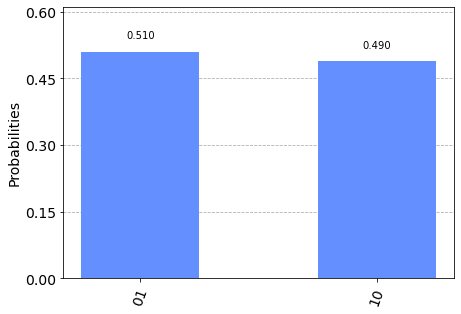

In [7]:
qc = alice_and_bob(3, measure=True)
backend = QasmSimulator()
qc_compiled = transpile(qc, backend)
job_sim = backend.run(qc_compiled, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)
plot_histogram(counts)